# LASSO回归分析

## $\S1$ Configuration & Data Preparation

In [41]:
# Configuration
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## Data Path
Path = "./Raw_Data_4.xlsx"
Dependent_Variable = "USD_index_Close"

## Param Grid
param_grid = {
    "model__alpha": np.logspace(-4, 1, 500)
}

## CV Scoring
scoring = {
    ### sklearn默认maximize the score, so we use prefix "neg"
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}


In [42]:
# Data Preparation
## Loading Data
Data = pd.read_excel(Path, index_col="日期")
print("Data Size:", Data.shape)

## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
scaler_y = StandardScaler()
# X,y = X.values, y.values

Data Size: (3223, 29)


In [ ]:
### Split Train, Valid and Test Sets
train_size = int(len(Data) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]


#### Split Train Set into Tims Series
tsCV = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tsCV.split(X_train)):
    print(f"Fold {fold}: Train {len(train_idx)}, Test {len(test_idx)}")


Fold 0: Train 433, Test 429
Fold 1: Train 862, Test 429
Fold 2: Train 1291, Test 429
Fold 3: Train 1720, Test 429
Fold 4: Train 2149, Test 429


## $\S2$ Model Training & Predicting

In [44]:
## Generating Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(random_state=42)),
]
)

## Model Selection
### Grid_Search with Pipe on Grid using TimeSeriesSplit CV on Train Set
gsCV = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv = tsCV,
    scoring = scoring,
    refit = "R2",
    n_jobs = -1,
    verbose=1
)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,{'model__alpha': array([1.0000...00000000e+01])}
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [45]:
### printing best model
#### Best Hyper Parameters:
print("Grid Search 最佳参数: ", gsCV.best_params_)
print("对应的(CV平均)最优R2:", gsCV.best_score_)

#### CV Results:
result = pd.DataFrame(gsCV.cv_results_)
cols_to_show = ["param_model__alpha", "mean_test_RMSE", "mean_test_MAE", "mean_test_R2"]
result["mean_test_MAE"] = -result["mean_test_MAE"]
result["mean_test_RMSE"] = -result["mean_test_RMSE"]
print(result[cols_to_show].sort_values(by="mean_test_R2", ascending=False).head(10))

Grid Search 最佳参数:  {'model__alpha': np.float64(0.14005305453932196)}
对应的(CV平均)最优R2: 0.006604468192877899
     param_model__alpha  mean_test_RMSE  mean_test_MAE  mean_test_R2
314            0.140053        1.016462       0.769968      0.006604
313            0.136859        1.016369       0.770083      0.006536
315            0.143322        1.016655       0.769934      0.006484
312            0.133737        1.016328       0.770227      0.006371
316            0.146667        1.016881       0.769921      0.006308
311            0.130687        1.016316       0.770372      0.006159
317            0.150090        1.017142       0.769909      0.006074
310            0.127706        1.016331       0.770527      0.005903
318            0.153593        1.017436       0.769901      0.005787
309            0.124794        1.016371       0.770692      0.005606


In [46]:
## Model Prediction
### 在gsCV中，refit已经选取了最优模型，Pipe在整个训练集上进行了重新训练
best_lasso = gsCV.best_estimator_
best_lasso.named_steps["model"].alpha
y_pred = best_lasso.predict(X_test)

Text(0.5, 1.0, 'LASSO Regression Prediction')

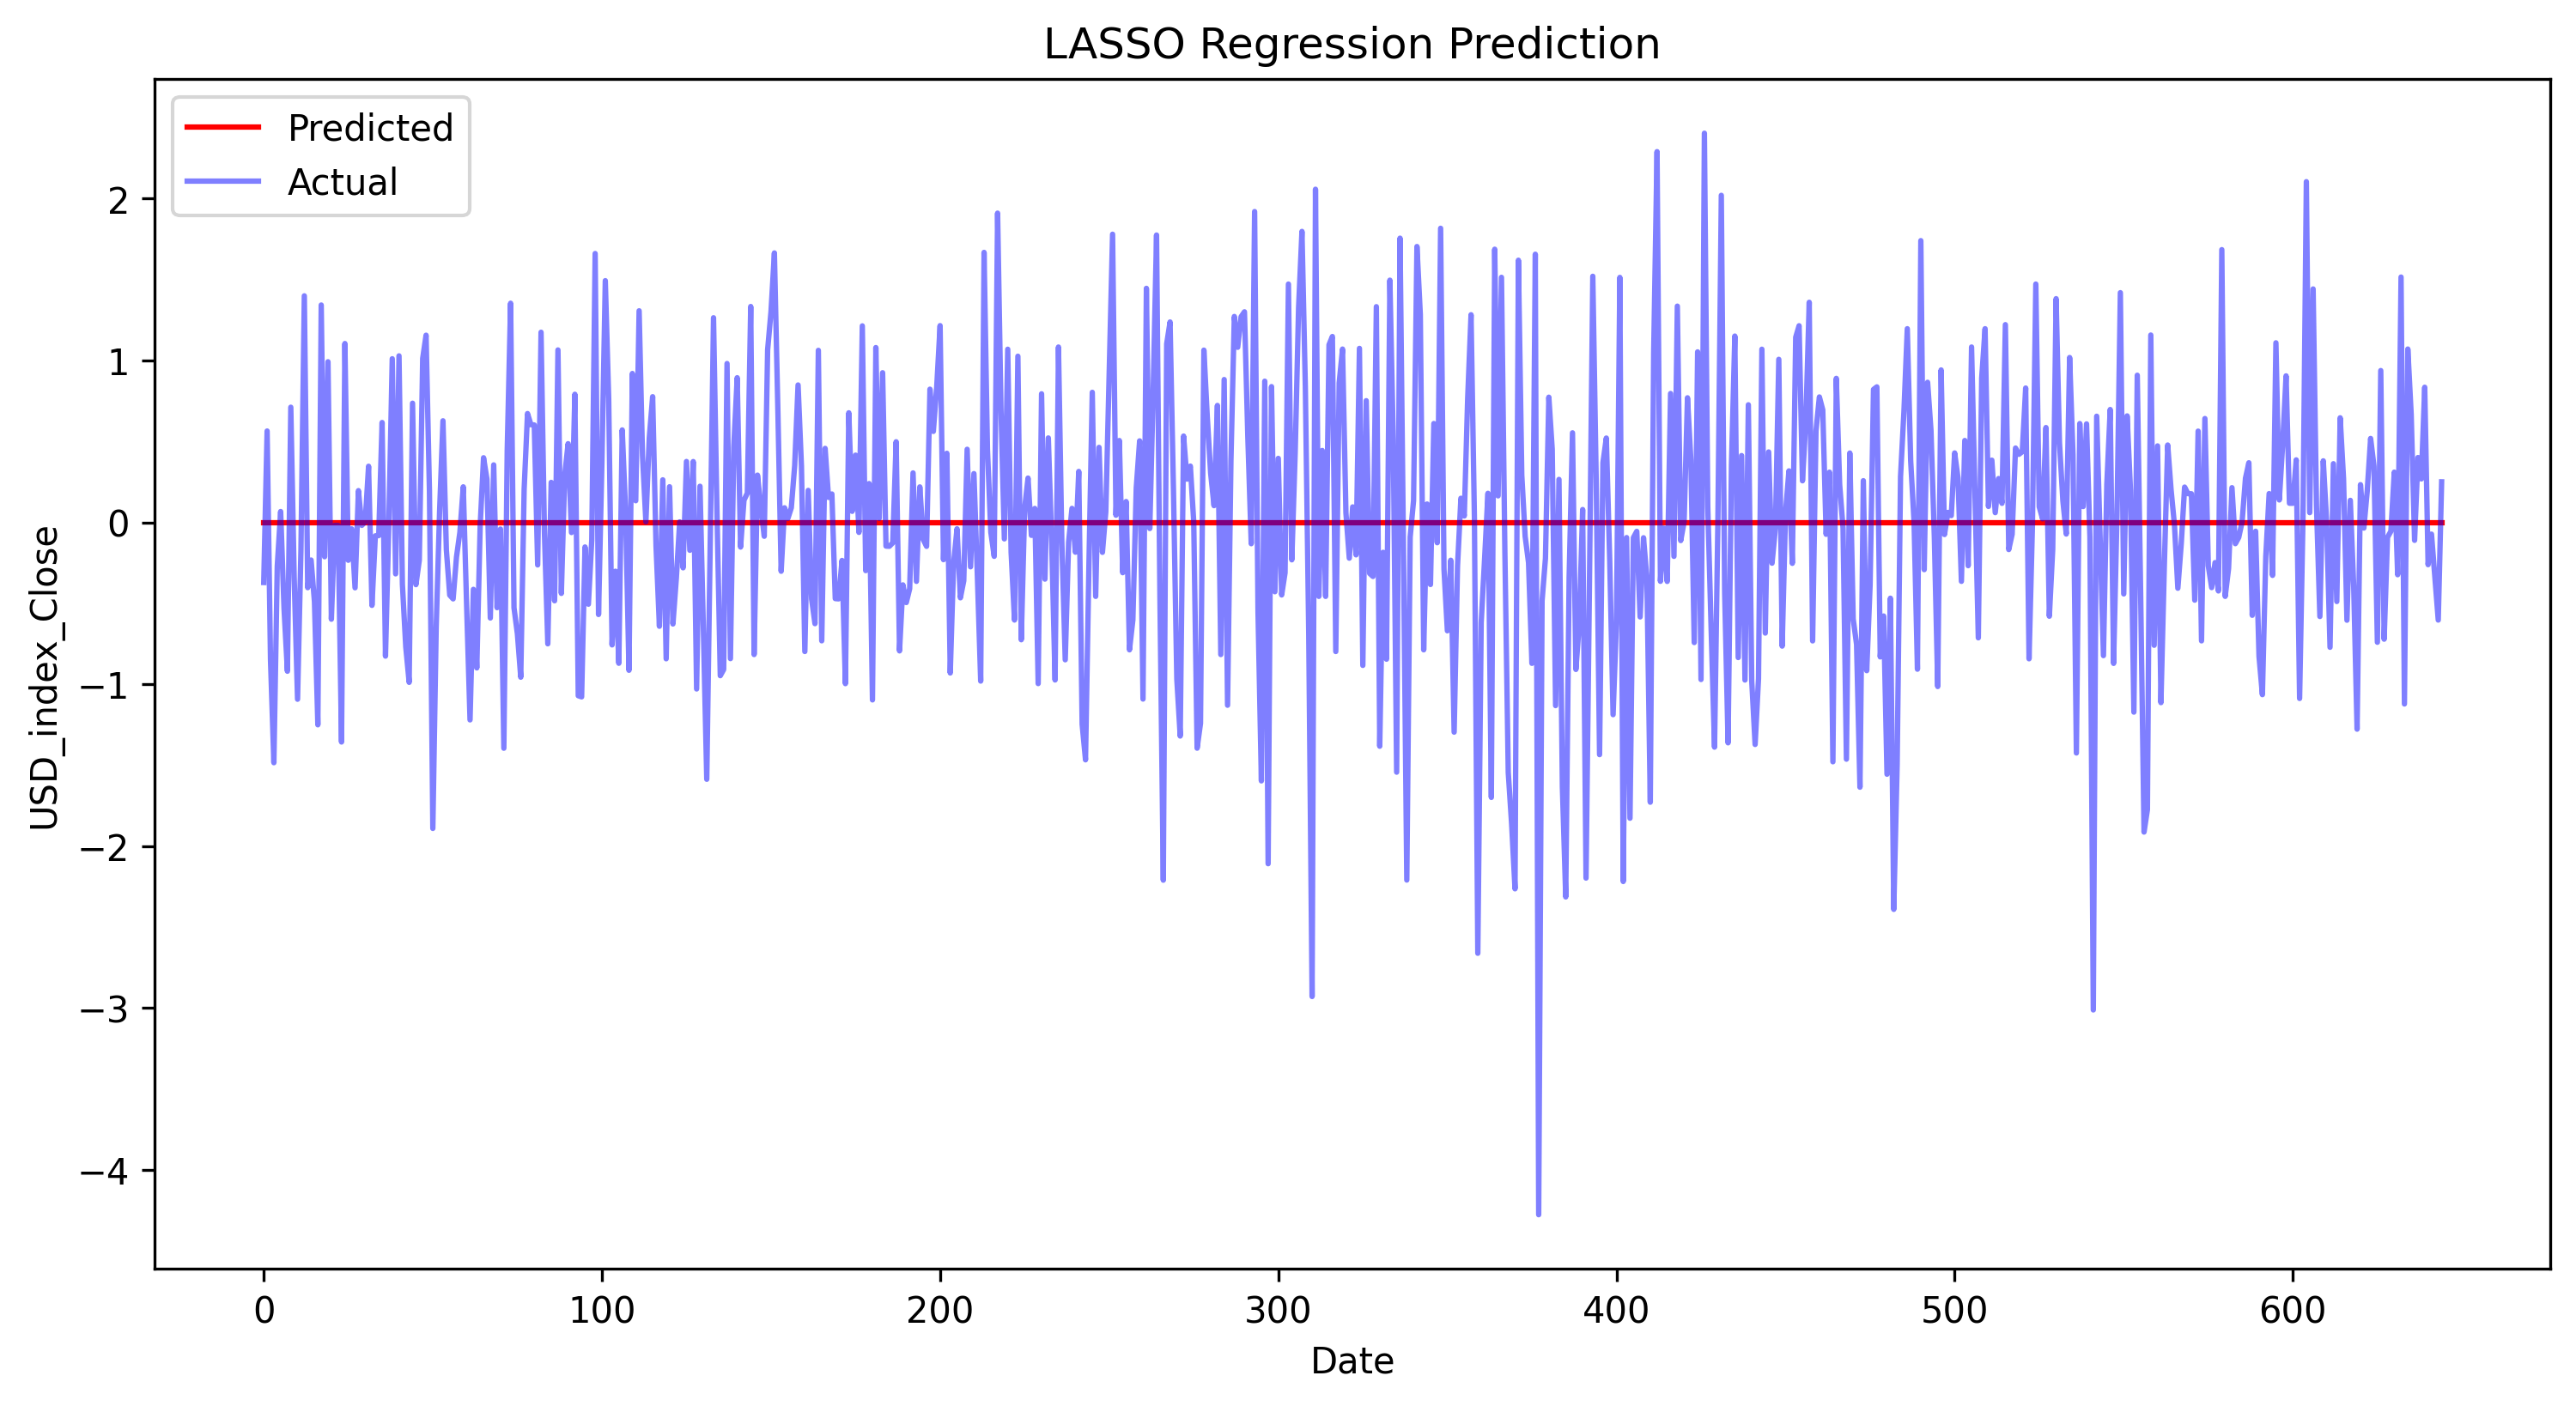

In [47]:
### Prediction Visualization
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test, label="Actual", color="blue", alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD_index_Close")
ax1.legend()
ax1.set_title("LASSO Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [48]:
## Model Evaluation
# 4.2 计算测试集指标
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("=== 测试集表现 ===")
print(f"MAE  : {test_mae:.6f}")
print(f"RMSE  : {test_rmse:.6f}")
print(f"R^2  : {test_r2:.6f}")

=== 测试集表现 ===
MAE  : 0.654071
RMSE  : 0.858786
R^2  : -0.000102
